In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "24" 

import sys 
sys.path.insert(0, "/genesis/jwst/jwst-ref-soss/fortran_lib/transitfit/")   #pre-compiled Fortran library for python.

import numpy as np
import matplotlib
import matplotlib.pyplot  as plt

#Import module
import transitfit5 as tf #import transitfit5 modules
import tfit5 as tfit5 #Fortran-low-level modules

import math

from scipy.stats import binned_statistic #for binned data.

from tqdm.notebook import trange

#import corner

#Modules for timing (not needed for production)
import time

In [2]:
WORKING_DIR = '/home/kmorel/ongenesis/jwst-user-soss/PHY3030/WASP_52/'

## Functions to move to external file.. 

In [3]:
class phot_class:
    def __init__(self):
        # Initialize arrays
        self.wavelength = []  # Wavelength of observation (should be a single number)
        self.time = []        # Time-stamps array -- mid-exposure time (days)
        self.flux = []        # Observed flux array 
        self.ferr = []        # Error in flux array
        self.itime = []       # Integration time (seconds)
        
class psg_class:
    def __init__(self):
        # Initialize arrays
        self.wavelength = []  # Wavelength of observation array
        self.flux = []        # Observed transit-depth due to atmosphere (ppm)
        self.ferr = []        # Predicted noise (ppm)
        
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1  # array[idx-1]
    else:
        return idx    # array[idx]
        
def read_model(filename):
    '''
    Reads in simple space delimited textfile.
    '''
    data = []
    f = open(filename)
    icount = -1
    for line in f:
        line = line.strip()
        columns = line.split()  # Break into columns
        icount += 1
        if(icount > 0) & (columns[0]!='#'):  # Skip header info
            data.append([float(i) for i in columns])
            #data.append(columns)
    f.close()
    return data

class sptransit_model_class(object):
    def __init__(self):
        self.wavelength = []     # Wavelength of each observation 
        
        self.rhostar = []        # Mean stellar density
        self.ld1 = []            # Limb-darkening. Set ld1=ld2=0 and ld3=q1 and ld4=q2
        self.ld2 = []  
        self.ld3 = []  
        self.ld4 = []  
        self.dilution = []       # Stellar dilution 0=none, 0.99 means 99% of light from other source
        self.zeropoint = []      # Out of transit baseline
        
        self.nplanet = 1         # Number of planets
        self.t0 = []             # Center of transit time
        self.period = []         # Orbital period
        self.b = []              # Impact parameter
        self.rprs = []           # Scale planet radius 
        self.sqrt_e_cosw = []    # sqrt(e)cos(w)
        self.sqrt_e_sinw = []    # sqrt(e)cos(w)
        self.eclipse_depth = []  # Secondard eclipse depth (ppm)
        self.ellipsoidal = []    # Amplitude of ellipsoidal variations (ppm)
        self.phasecurve = []     # Amplitude of reflected/emission phase curve (ppm) - Lambertian
        
        self.error_scale = []      # Scale to apply to photometric errors
        self.amplitude_scale = []  # GP Kernel Amplitude (default is Matern 3/2)
        self.length_scale = []     # GP length scale (default is Matern 3/2)
        
        self.ntt = []            # Parameters for TTVs ntt = number of transit times
        self.tobs = []           # Observed centre of transit times
        self.omc = []            # O-C values for eachtransit

class sptransit_model_parameters(sptransit_model_class):
    def __init__(self, num):
        sptransit_model_class.__init__(self)
        nwav = len(num[0])
        
        # Wavelength for each dataset
        zpt = []
        for p in num[0]:
            self.wavelength.append(p.wavelength)
            zpt.append(np.median(p.flux))
        zpt = np.array(zpt)
            
        # Star Parameters
        self.rhostar = [np.ones(1),'bolometric','fit',np.array([1.0e-4,1000])]     
        self.ld1 = [np.zeros(nwav),'chromatic','fixed',np.array([-1,1])]  
        self.ld2 = [np.zeros(nwav),'chromatic','fixed',np.array([-1,1])]  
        self.ld3 = [np.ones(nwav)*0.5,'chromatic','fit',np.array([0,1])]  
        self.ld4 = [np.ones(nwav)*0.5,'chromatic','fit',np.array([0,1])]  
        self.dilution = [np.zeros(nwav),'chromatic','fixed',np.array([0,1])]
        self.zeropoint = [zpt,'chromatic','fit',np.array([0,1.0e9])]
        
        # Planet Parameters
        nplanet = num[1]
        self.nplanet = num[1]*1
        for i in range(nplanet):
            self.t0.append([np.ones(1),'bolometric','fit',np.array([0,2])])
            self.period.append([np.ones(1),'bolometric','fit',np.array([0,2])])
            self.b.append([np.ones(1)*0.5,'bolometric','fit',np.array([0,2])])
            self.rprs.append([np.ones(nwav)*0.01,'chromatic','fit',np.array([0,1])])
            self.sqrt_e_cosw.append([np.zeros(1),'bolometric','fixed',np.array([-1,1])])
            self.sqrt_e_sinw.append([np.zeros(1),'bolometric','fixed',np.array([-1,1])])
            self.eclipse_depth.append([np.zeros(nwav),'chromatic','fixed',np.array([0,1.0e4])])
            self.ellipsoidal.append([np.zeros(nwav),'chromatic','fixed',np.array([0,1.0e4])])
            self.phasecurve.append([np.zeros(nwav),'chromatic','fixed',np.array([0,1.0e4])])
            
        # Error model
        self.error_scale = [np.ones(1)*1.0,'bolometric','fit',np.array([0,2])]
        self.amplitude_scale = [np.ones(nwav)*1.0,'chromatic','fixed',np.array([0,2000])]
        self.length_scale = [np.ones(nwav)*1.0,'chromatic','fixed',np.array([0,1])]
        
        self.ntt = 0
        self.tobs = 0
        self.omc = 0
        
        
def get_fitted_parameters(tpars):
    
    x = []
    
    if tpars.rhostar[2]=='fit':
        for p in tpars.rhostar[0]:
            x.append(p)
            
    if tpars.ld1[2]=='fit':
        for p in tpars.ld1[0]:
            x.append(p)
            
    if tpars.ld2[2]=='fit':
        for p in tpars.ld2[0]:
            x.append(p)
            
    if tpars.ld3[2]=='fit':
        for p in tpars.ld3[0]:
            x.append(p)
            
    if tpars.ld4[2]=='fit':
        for p in tpars.ld4[0]:
            x.append(p)
            
    if tpars.dilution[2]=='fit':
        for p in tpars.dilution[0]:
            x.append(p)
            
    if tpars.zeropoint[2]=='fit':
        for p in tpars.zeropoint[0]:
            x.append(p)
            
    for i in range(tpars.nplanet):
            
        if tpars.t0[i][2]=='fit':
            for p in tpars.t0[i][0]:
                x.append(p)
                
        if tpars.period[i][2]=='fit':
            for p in tpars.period[i][0]:
                x.append(p)
                
        if tpars.b[i][2]=='fit':
            for p in tpars.b[i][0]:
                x.append(p)
                
        if tpars.rprs[i][2]=='fit':
            for p in tpars.rprs[i][0]:
                x.append(p)
                
        if tpars.sqrt_e_cosw[i][2]=='fit':
            for p in tpars.sqrt_e_cosw[i][0]:
                x.append(p)
                
        if tpars.sqrt_e_sinw[i][2]=='fit':
            for p in tpars.sqrt_e_sinw[i][0]:
                x.append(p)
        
        if tpars.eclipse_depth[i][2]=='fit':
            for p in tpars.eclipse_depth[i][0]:
                x.append(p)
        
        if tpars.ellipsoidal[i][2]=='fit':
            for p in tpars.ellipsoidal[i][0]:
                x.append(p)
                
        if tpars.phasecurve[i][2]=='fit':
            for p in tpars.phasecurve[i][0]:
                x.append(p)
                
    if tpars.error_scale[2]=='fit':
        for p in tpars.error_scale[0]:
            x.append(p)
            
    if tpars.amplitude_scale[2]=='fit':
        for p in tpars.amplitude_scale[0]:
            x.append(p)
            
    if tpars.length_scale[2]=='fit':
        for p in tpars.length_scale[0]:
            x.append(p)
        
    x = np.array(x)
    
    return x

def get_all_parameters(tpars, photospectra):
    
    nhp = 3  # Potential number of hyper-parameters
    
    npars = 8 + 10*tpars.nplanet + nhp
    nwav = len(photospectra)
    
    sol = np.zeros([npars, nwav])
    
    if tpars.rhostar[1]=='bolometric':
        sol[0][:] = np.ones(nwav)*tpars.rhostar[0][0]
    else:
        sol[0][:] = tpars.rhostar[0]
        
    if tpars.ld1[1]=='bolometric':
        sol[1][:] = np.ones(nwav)*tpars.ld1[0][0]
    else:
        sol[1][:] = tpars.ld1[0]
        
    if tpars.ld2[1]=='bolometric':
        sol[2][:] = np.ones(nwav)*tpars.ld2[0][0]
    else:
        sol[2][:] = tpars.ld2[0]
        
    if tpars.ld3[1]=='bolometric':
        sol[3][:] = np.ones(nwav)*tpars.ld3[0][0]
    else:
        sol[3][:] = tpars.ld3[0]
        
    if tpars.ld4[1]=='bolometric':
        sol[4][:] = np.ones(nwav)*tpars.ld4[0][0]
    else:
        sol[4][:] = tpars.ld4[0]
        
    if tpars.dilution[1]=='bolometric':
        sol[5][:] = np.ones(nwav)*tpars.dilution[0][0]
    else:
        sol[5][:] = tpars.dilution[0]
        
    if tpars.zeropoint[1]=='bolometric':
        sol[7][:] = np.ones(nwav)*tpars.zeropoint[0][0]
    else:
        sol[7][:] = tpars.zeropoint[0]
        
    for i in range(tpars.nplanet):
        nc = 10*i
        
        if tpars.t0[i][1]=='bolometric':
            sol[8+nc][:] = np.ones(nwav)*tpars.t0[i][0][0]
        else:
            sol[8+nc][:] = tpars.t0[i][0]
            
        if tpars.period[i][1]=='bolometric':
            sol[9+nc][:] = np.ones(nwav)*tpars.period[i][0][0]
        else:
            sol[9+nc][:] = tpars.period[i][0]
            
        if tpars.b[i][1]=='bolometric':
            sol[10+nc][:] = np.ones(nwav)*tpars.b[i][0][0]
        else:
            sol[10+nc][:] = tpars.b[i][0]
            
        if tpars.rprs[i][1]=='bolometric':
            sol[11+nc][:] = np.ones(nwav)*tpars.rprs[i][0][0]
        else:
            sol[11+nc][:] = tpars.rprs[i][0]
            
        if tpars.sqrt_e_cosw[i][1]=='bolometric':
            sol[12+nc][:] = np.ones(nwav)*tpars.sqrt_e_cosw[i][0][0]
        else:
            sol[12+nc][:] = tpars.sqrt_e_cosw[i][0]
            
        if tpars.sqrt_e_sinw[i][1]=='bolometric':
            sol[13+nc][:] = np.ones(nwav)*tpars.sqrt_e_sinw[i][0][0]
        else:
            sol[13+nc][:] = tpars.sqrt_e_sinw[i][0]
            
        if tpars.eclipse_depth[i][1]=='bolometric':
            sol[15+nc][:] = np.ones(nwav)*tpars.eclipse_depth[i][0][0]
        else:
            sol[15+nc][:] = tpars.eclipse_depth[i][0]
            
        if tpars.ellipsoidal[i][1]=='bolometric':
            sol[16+nc][:] = np.ones(nwav)*tpars.ellipsoidal[i][0][0]
        else:
            sol[16+nc][:] = tpars.ellipsoidal[i][0]
        
        if tpars.phasecurve[i][1]=='bolometric':
            sol[17+nc][:] = np.ones(nwav)*tpars.phasecurve[i][0][0]
        else:
            sol[17+nc][:] = tpars.phasecurve[i][0]
    
    if tpars.error_scale[2]=='fit':
        if tpars.error_scale[1]=='bolometric':
            sol[npars-3][:]=np.ones(nwav)*tpars.error_scale[0][0]
        else:
            sol[npars-3][:]=tpars.error_scale[0]
            
    if tpars.amplitude_scale[2]=='fit':
        if tpars.amplitude_scale[1]=='bolometric':
            sol[npars-2][:]=np.ones(nwav)*tpars.amplitude_scale[0][0]
        else:
            sol[npars-2][:]=tpars.amplitude_scale[0]
            
    if tpars.length_scale[2]=='fit':
        if tpars.length_scale[1]=='bolometric':
            sol[npars-2][:]=np.ones(nwav)*tpars.length_scale[0][0]
        else:
            sol[npars-2][:]=tpars.length_scale[0]
    
    return sol

def update_sol(tpars, x, sol):
    '''
    Uses tpars and x to make an parameter set that will work with our transit model.
    '''
    
    solnew=np.copy(sol) #make a copy of the input sol array.
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
    
    xc=0 #counts position as we work through the x array.
    
    if tpars.rhostar[2]=='fit':
        if tpars.rhostar[1]=='bolometric':
            solnew[0][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[0][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.ld1[2]=='fit':
        if tpars.ld1[1]=='bolometric':
            solnew[1][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[1][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.ld2[2]=='fit':
        if tpars.ld2[1]=='bolometric':
            solnew[2][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[2][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.ld3[2]=='fit':
        if tpars.ld3[1]=='bolometric':
            solnew[3][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[3][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.ld4[2]=='fit':
        if tpars.ld4[1]=='bolometric':
            solnew[4][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[4][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.dilution[2]=='fit':
        if tpars.dilution[1]=='bolometric':
            solnew[5][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[5][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.zeropoint[2]=='fit':
        if tpars.zeropoint[1]=='bolometric':
            solnew[7][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[7][:]=x[xc:xc+nwav]
            xc+=nwav
            
    for i in range(tpars.nplanet):
        nc=10*i
        
        if tpars.t0[i][2]=='fit':
            if tpars.t0[i][1]=='bolometric':
                solnew[8+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[8+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.period[i][2]=='fit':
            if tpars.period[i][1]=='bolometric':
                solnew[9+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[9+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.b[i][2]=='fit':
            if tpars.b[i][1]=='bolometric':
                solnew[10+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[10+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.rprs[i][2]=='fit':
            if tpars.rprs[i][1]=='bolometric':
                solnew[11+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[11+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.sqrt_e_cosw[i][2]=='fit':
            if tpars.sqrt_e_cosw[i][1]=='bolometric':
                solnew[12+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[12+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.sqrt_e_sinw[i][2]=='fit':
            if tpars.sqrt_e_sinw[i][1]=='bolometric':
                solnew[13+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[13+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.eclipse_depth[i][2]=='fit':
            if tpars.eclipse_depth[i][1]=='bolometric':
                solnew[15+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[15+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.amplitude_scale[i][2]=='fit':
            if tpars.amplitude_scale[i][1]=='bolometric':
                solnew[16+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[16+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.length_scale[i][2]=='fit':
            if tpars.length_scale[i][1]=='bolometric':
                solnew[17+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[17+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
                
    if tpars.error_scale[2]=='fit':
        if tpars.error_scale[1]=='bolometric':
            solnew[npars-3][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[npars-3][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.amplitude_scale[2]=='fit':
        if tpars.amplitude_scale[1]=='bolometric':
            solnew[npars-2][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[npars-2][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.length_scale[2]=='fit':
        if tpars.length_scale[1]=='bolometric':
            solnew[npars-2][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[npars-2][:]=x[xc:xc+nwav]
            xc+=nwav           
    

    return solnew

def tran_ll_transform(cube):
    params = cube.copy() #cube contains random draws that need to be mapped to params 
    ncube=len(cube) #number of parameters that need to be mapped.
    
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
                
    xc=0 #counter to keep track of how many parmaters we have.
    
    if tpars.rhostar[2]=='fit':
        lo=tpars.rhostar[3][0]
        hi=tpars.rhostar[3][1]
        if tpars.rhostar[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.ld1[2]=='fit':
        lo=tpars.ld1[3][0]
        hi=tpars.ld1[3][1]
        if tpars.ld1[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.ld2[2]=='fit':
        lo=tpars.ld2[3][0]
        hi=tpars.ld2[3][1]
        if tpars.ld2[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.ld3[2]=='fit':
        lo=tpars.ld3[3][0]
        hi=tpars.ld3[3][1]
        if tpars.ld3[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.ld4[2]=='fit':
        lo=tpars.ld4[3][0]
        hi=tpars.ld4[3][1]
        if tpars.ld4[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.dilution[2]=='fit':
        lo=tpars.dilution[3][0]
        hi=tpars.dilution[3][1]
        if tpars.dilution[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.zeropoint[2]=='fit':
        lo=tpars.zeropoint[3][0]
        hi=tpars.zeropoint[3][1]
        if tpars.zeropoint[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    for i in range(tpars.nplanet):
        nc=10*i
        
        if tpars.t0[i][2]=='fit':
            lo=tpars.t0[i][3][0]
            hi=tpars.t0[i][3][1]
            if tpars.t0[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
        
        if tpars.period[i][2]=='fit':
            lo=tpars.period[i][3][0]
            hi=tpars.period[i][3][1]
            if tpars.period[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.b[i][2]=='fit':
            lo=tpars.b[i][3][0]
            hi=tpars.b[i][3][1]
            if tpars.b[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.rprs[i][2]=='fit':
            lo=tpars.rprs[i][3][0]
            hi=tpars.rprs[i][3][1]
            if tpars.rprs[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.sqrt_e_cosw[i][2]=='fit':
            lo=tpars.sqrt_e_cosw[i][3][0]
            hi=tpars.sqrt_e_cosw[i][3][1]
            if tpars.sqrt_e_cosw[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.sqrt_e_sinw[i][2]=='fit':
            lo=tpars.sqrt_e_sinw[i][3][0]
            hi=tpars.sqrt_e_sinw[i][3][1]
            if tpars.sqrt_e_sinw[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.eclipse_depth[i][2]=='fit':
            lo=tpars.eclipse_depth[i][3][0]
            hi=tpars.eclipse_depth[i][3][1]
            if tpars.eclipse_depth[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.amplitude_scale[i][2]=='fit':
            lo=tpars.amplitude_scale[i][3][0]
            hi=tpars.amplitude_scale[i][3][1]
            if tpars.amplitude_scale[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.length_scale[i][2]=='fit':
            lo=tpars.length_scale[i][3][0]
            hi=tpars.length_scale[i][3][1]
            if tpars.length_scale[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
    if tpars.error_scale[2]=='fit':
        lo=tpars.error_scale[3][0]
        hi=tpars.error_scale[3][1]
        if tpars.error_scale[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.amplitude_scale[2]=='fit':
        lo=tpars.amplitude_scale[3][0]
        hi=tpars.amplitude_scale[3][1]
        if tpars.amplitude_scale[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.length_scale[2]=='fit':
        lo=tpars.length_scale[3][0]
        hi=tpars.length_scale[3][1]
        if tpars.length_scale[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
        
            
    return params

def get_names(clabels,tpars):
    '''Assign labels to all the parameters
    '''

    solnew=np.copy(sol) #make a copy of the input sol array.
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
    
    tran_par_names=[]
    
    if tpars.rhostar[2]=='fit':
        if tpars.rhostar[1]=='bolometric':
            tran_par_names.append(clabels[0])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[0])
            
    if tpars.ld1[2]=='fit':
        if tpars.ld1[1]=='bolometric':
            tran_par_names.append(clabels[1])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[1])
            
    if tpars.ld2[2]=='fit':
        if tpars.ld2[1]=='bolometric':
            tran_par_names.append(clabels[2])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[2])
            
    if tpars.ld3[2]=='fit':
        if tpars.ld3[1]=='bolometric':
            tran_par_names.append(clabels[3])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[3])
            
    if tpars.ld4[2]=='fit':
        if tpars.ld4[1]=='bolometric':
            tran_par_names.append(clabels[4])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[4])
            
    if tpars.dilution[2]=='fit':
        if tpars.dilution[1]=='bolometric':
            tran_par_names.append(clabels[5])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[5])
            
    if tpars.zeropoint[2]=='fit':
        if tpars.zeropoint[1]=='bolometric':
            tran_par_names.append(clabels[7])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[7])
            
    for i in range(tpars.nplanet):
        nc=10*i
        
        if tpars.t0[i][2]=='fit':
            if tpars.t0[i][1]=='bolometric':
                tran_par_names.append(clabels[8])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[8])
                
        if tpars.period[i][2]=='fit':
            if tpars.period[i][1]=='bolometric':
                tran_par_names.append(clabels[9])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[9])
                
        if tpars.b[i][2]=='fit':
            if tpars.b[i][1]=='bolometric':
                tran_par_names.append(clabels[10])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[10])
                
        if tpars.rprs[i][2]=='fit':
            if tpars.rprs[i][1]=='bolometric':
                tran_par_names.append(clabels[11])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[11])
                
        if tpars.sqrt_e_cosw[i][2]=='fit':
            if tpars.sqrt_e_cosw[i][1]=='bolometric':
                tran_par_names.append(clabels[12])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[12])
                
        if tpars.sqrt_e_sinw[i][2]=='fit':
            if tpars.sqrt_e_sinw[i][1]=='bolometric':
                tran_par_names.append(clabels[13])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[13])
                
        if tpars.eclipse_depth[i][2]=='fit':
            if tpars.eclipse_depth[i][1]=='bolometric':
                tran_par_names.append(clabels[15])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[15])
                
        if tpars.amplitude_scale[i][2]=='fit':
            if tpars.amplitude_scale[i][1]=='bolometric':
                tran_par_names.append(clabels[16])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[16])
                
        if tpars.length_scale[i][2]=='fit':
            if tpars.length_scale[i][1]=='bolometric':
                tran_par_names.append(clabels[17])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[17])
                
                
    if tpars.error_scale[2]=='fit':
        if tpars.error_scale[1]=='bolometric':
            tran_par_names.append(clabels[18])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[18])
            
    if tpars.amplitude_scale[2]=='fit':
        if tpars.amplitude_scale[1]=='bolometric':
            tran_par_names.append(clabels[19])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[19])
            
    if tpars.length_scale[2]=='fit':
        if tpars.length_scale[1]=='bolometric':
            tran_par_names.append(clabels[20])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[20])
                
    return tran_par_names

def checksolution(tpars,solnew,badlpr):
    '''Make sure model parameters are valid.
    '''
    
    logl=1.0e0
    
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
    
    for i in range(nwav):
        sol1=np.array([s[i] for s in solnew])
        
        
        if tpars.rhostar[2]=='fit':
            lo=tpars.rhostar[3][0]
            hi=tpars.rhostar[3][1]
            if (sol1[0]>hi)|(sol1[0]<lo):
                logl=badlpr
                
        if tpars.ld1[2]=='fit':
            lo=tpars.ld1[3][0]
            hi=tpars.ld1[3][1]
            if (sol1[1]>hi)|(sol1[1]<lo):
                logl=badlpr
                
        if tpars.ld2[2]=='fit':
            lo=tpars.ld2[3][0]
            hi=tpars.ld2[3][1]
            if (sol1[2]>hi)|(sol1[2]<lo):
                logl=badlpr
                
        if tpars.ld3[2]=='fit':
            lo=tpars.ld3[3][0]
            hi=tpars.ld3[3][1]
            if (sol1[3]>hi)|(sol1[3]<lo):
                logl=badlpr
                
        if tpars.ld4[2]=='fit':
            lo=tpars.ld4[3][0]
            hi=tpars.ld4[3][1]
            if (sol1[4]>hi)|(sol1[4]<lo):
                logl=badlpr
                
        if tpars.dilution[2]=='fit':
            lo=tpars.dilution[3][0]
            hi=tpars.dilution[3][1]
            if (sol1[5]>hi)|(sol1[5]<lo):
                logl=badlpr
                
        if tpars.zeropoint[2]=='fit':
            lo=tpars.zeropoint[3][0]
            hi=tpars.zeropoint[3][1]
            if (sol1[7]>hi)|(sol1[7]<lo):
                logl=badlpr
                
        for i in range(tpars.nplanet):
            nc=10*i
            
            if tpars.t0[i][2]=='fit':
                lo=tpars.t0[i][3][0]
                hi=tpars.t0[i][3][1]
                if (sol1[8+nc]>hi)|(sol1[8+nc]<lo):
                    logl=badlpr
                    
            if tpars.period[i][2]=='fit':
                lo=tpars.period[i][3][0]
                hi=tpars.period[i][3][1]
                if (sol1[9+nc]>hi)|(sol1[9+nc]<lo):
                    logl=badlpr
                    
            if tpars.b[i][2]=='fit':
                lo=tpars.b[i][3][0]
                hi=tpars.b[i][3][1]
                if (sol1[10+nc]>hi)|(sol1[10+nc]<lo):
                    logl=badlpr
                    
            if tpars.rprs[i][2]=='fit':
                lo=tpars.rprs[i][3][0]
                hi=tpars.rprs[i][3][1]
                if (sol1[11+nc]>hi)|(sol1[11+nc]<lo):
                    logl=badlpr
                    
            if tpars.sqrt_e_cosw[i][2]=='fit':
                lo=tpars.sqrt_e_cosw[i][3][0]
                hi=tpars.sqrt_e_cosw[i][3][1]
                if (sol1[12+nc]>hi)|(sol1[12+nc]<lo):
                    logl=badlpr
                    
            if tpars.sqrt_e_sinw[i][2]=='fit':
                lo=tpars.sqrt_e_sinw[i][3][0]
                hi=tpars.sqrt_e_sinw[i][3][1]
                if (sol1[13+nc]>hi)|(sol1[13+nc]<lo):
                    logl=badlpr
                    
            if tpars.eclipse_depth[i][2]=='fit':
                lo=tpars.eclipse_depth[i][3][0]
                hi=tpars.eclipse_depth[i][3][1]
                if (sol1[15+nc]>hi)|(sol1[15+nc]<lo):
                    logl=badlpr
                    
            if tpars.amplitude_scale[i][2]=='fit':
                lo=tpars.amplitude_scale[i][3][0]
                hi=tpars.amplitude_scale[i][3][1]
                if (sol1[15+nc]>hi)|(sol1[15+nc]<lo):
                    logl=badlpr
                    
            if tpars.length_scale[i][2]=='fit':
                lo=tpars.length_scale[i][3][0]
                hi=tpars.length_scale[i][3][1]
                if (sol1[15+nc]>hi)|(sol1[15+nc]<lo):
                    logl=badlpr
                    
        if tpars.error_scale[2]=='fit':
            lo=tpars.error_scale[3][0]
            hi=tpars.error_scale[3][1]
            if (sol1[npars-3]>hi)|(sol1[npars-3]<lo):
                logl=badlpr
                
        if tpars.amplitude_scale[2]=='fit':
            lo=tpars.amplitude_scale[3][0]
            hi=tpars.amplitude_scale[3][1]
            if (sol1[npars-2]>hi)|(sol1[npars-2]<lo):
                logl=badlpr
                
        if tpars.length_scale[2]=='fit':
            lo=tpars.length_scale[3][0]
            hi=tpars.length_scale[3][1]
            if (sol1[npars-1]>hi)|(sol1[npars-1]<lo):
                logl=badlpr
            

    return logl

In [4]:
def gelmanrubin(*chain, burnin, npt):
    # See pdf doc BrooksGelman for info
    "Estimating PSRF"
    M = len(chain)                    # Number of chains
    N = chain[0].shape[0]-burnin      # Assuming all chains have the same size.
    npars = chain[0].shape[1]         # Number of parameters
    pmean = np.zeros(shape=(M,npars)) # Allocate array to hold mean calculations 
    pvar = np.zeros(shape=(M,npars))  # Allocate array to hold variance calculations

    for i in range(0, M):
        currentchain = chain[i]
        for j in range(0, npars):
            pmean[i,j] = np.mean(currentchain[burnin:,j]) # Generate means for each parameter in each chain
            pvar[i,j] = np.var(currentchain[burnin:,j])   # Generate variance for each parameter in each chain
    
    posteriormean = np.zeros(npars)  # Allocate array for posterior means
    for j in range(0, npars):
        posteriormean[j] = np.mean(pmean[:,j])  # Calculate posterior mean for each parameter
        
    # Calculate between chains variance
    B = np.zeros(npars)
    for j in range(0, npars):
        for i in range(0, M):
            B[j] += np.power((pmean[i,j]-posteriormean[j]),2)
    B = B*N/(M-1.0)    
    
    # Calculate within chain variance
    W = np.zeros(npars)
    for j in range(0, npars):
        for i in range(0, M):
            W[j] += pvar[i,j]
    W = W/M 
    
    
    #Calculate the pooled variance
    V = (N-1)*W/N + (M+1)*B/(M*N)
    
    dof = npt-1   # Degrees of freedom 
    Rc = np.sqrt((dof+3.0)/(dof+1.0)*V/W)   # PSRF from Brooks and Gelman (1997)
    
    #Calculate Ru
    #qa=0.95
    #ru=np.sqrt((dof+3.0)/(dof+1.0)*((N-1.0)/N*W+(M+1.0)/M*qa))
    
    return Rc;

def demhmcmc(x, llx, loglikelihood, beta, buffer, corbeta):
    "A Metropolis-Hastings MCMC with Gibbs sampler"
    
    nbuffer = len(buffer[:,0])
    rsamp = np.random.rand() #draw a random number to decide which sampler to use
    
    if rsamp < 0.5: #if rsamp is less than 0.5 use a Gibbs sampler 

        xt=np.copy(x)                            #make a copy of our current state to the trail state
        npars=len(x)                             #number of parameters
        n=int(np.random.rand()*npars)            #random select a parameter to vary.
    
        xt[n]=xt[n]+np.random.normal(0.0,beta[n])#Step 2: Generate trial state with Gibbs sampler 

    else:   #use our deMCMC sampler

        n=-1 #tell the accept array that we used the deMCMC sampler
        i1=int(np.random.rand()*nbuffer)
        i2=int(np.random.rand()*nbuffer)
        vectorjump=buffer[i1,:]-buffer[i2,:]
        xt=x+vectorjump*corbeta
    
    llxt=loglikelihood(xt) #Step 3 Compute log(p(x'|d))=log(p(x'))+log(p(d|x'))
    
    alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability
    
    u=np.random.rand()                       #Step 5 generate a random number

    if u <= alpha:                           #Step 6, compare u and alpha
        xp1=np.copy(xt)                      #accept new trial
        llxp1=np.copy(llxt)
        ac=[0, n]                             #Set ac to mark acceptance
    else:
        xp1=np.copy(x)                       #reject new trial
        llxp1=np.copy(llx)
        ac=[1, n]                             #Set ac to mark rejectance
        
    xp1=np.array(xp1)
    return xp1,llxp1,ac;    

def betarescale(x,beta,niter,burnin,mcmcfunc,loglikelihood,imax=20):
    "Calculate rescaling of beta to improve acceptance rates"
    
    alow = 0.22  #alow, ahigh define the acceptance rate range we want
    ahigh = 0.28
    
    delta=0.01  #parameter controling how fast corscale changes - from Gregory 2011.
    
    npars=len(x)   #Number of parameters
    acorsub=np.zeros(npars) 
    nacor=np.zeros(npars)       #total number of accepted proposals
    nacorsub=np.zeros(npars)    #total number of accepted proposals immediately prior to rescaling
    npropp=np.zeros(npars)      #total number of proposals
    nproppsub=np.zeros(npars)   #total number of proposals immediately prior to rescaling
    acrate=np.zeros(npars)      #current acrate 
    corscale=np.ones(npars)
    
    #inital run
    chain,accept=genchain(x,niter,beta,mcmcfunc,loglikelihood) #Get a MC   
    nchain=len(chain[:,0])
    
    #calcalate initial values of npropp and nacor 
    for i in range(burnin,nchain):
        j=accept[i,1]           #get accept flag value
        npropp[j]+=1            #update total number of proposals
        nacor[j]+=1-accept[i,0] #update total number of accepted proposals
        
    #update x
    xin=chain[niter,:]  #we can continue to make chains by feeding the current state back into genchain
    
    acrate=nacor/npropp #inital acceptance rate
    
    afix=np.ones(npars)  #afix is an integer flag to indicate which beta entries need to be updated
    for i in range(0,npars):
        if (acrate[i]<ahigh)&(acrate[i]>alow):   #we strive for an acceptance rate between alow,ahigh
            afix[i]=0    #afix=1 : update beta, afix=0 : do not update beta

    #We will iterate a maximum of imax times - avoid infinite loops
    icount=0   #counter to track iterations
    while (np.sum(afix) > 0):
        icount+=1  #track number of iterations
        
        if icount>1:
            npropp=np.copy(nproppsub)
            nacor=np.copy(nacorsub)
        nacorsub=np.zeros(npars)  #reset nacorsub counts for each loop
        nproppsub=np.zeros(npars) #reset nproppsub counts for each loop
        
        #Make another chain starting with xin
        betain=beta*corscale   #New beta for Gibbs sampling  
        chain,accept=genchain(xin,niter,betain,mcmcfunc,loglikelihood) #Get a MC
        xin=chain[niter,:]     #Store current parameter state 
        
        for i in range(burnin,nchain): #scan through Markov-Chains and count number of states and acceptances 
            j=accept[i,1]
            #if acrate[j]>ahigh or acrate[j]<alow: 
            npropp[j]+=1            #update total number of proposals
            nacor[j]+=1-accept[i,0] #update total number of accepted proposals
            nproppsub[j]+=1            #Update current number of proposals
            nacorsub[j]+=1-accept[i,0] #Update current number of accepted proposals

        for i in range(0,npars):  #calculate acceptance rates for each parameter that is to updated 
            #calculate current acrates
            acrate[i]=nacorsub[i]/nproppsub[i]

            #calculate acorsub
            acorsub[i]=(nacor[i]-nacorsub[i])/(npropp[i]-nproppsub[i])
    
            if afix[i]>0:
                #calculate corscale
                corscale[i]=np.abs(corscale[i]*np.power((acorsub[i]+delta)\
                                                        *0.75/(0.25*(1.0-acorsub[i]+delta)) ,0.25))
        
        print('Current Acceptance: ',acrate) #report acceptance rates
        for i in range(0,npars):  #check which parameters have achieved required acceptance rate
            if acrate[i]<ahigh and acrate[i]>alow:
                afix[i]=0

        if(icount>imax):   #if too many iterations, then we give up and exit
            afix=np.zeros(npars)
            print("Too many iterations: icount > imax")
    
    print('Final Acceptance: ',acrate) #report acceptance rates
    
    return corscale;

def calcacrate(accept,burnin):#,label):
    "Calculate Acceptance Rates"
    nchain=len(accept[:,0])
    print ('%s %.3f' % ('Global Acceptance Rate:',(nchain-burnin-np.sum(accept[burnin:,0]))/(nchain-burnin)))

    for j in range(max(accept[burnin:,1])+1):
        denprop=0   #this is for deMCMC
        deacrate=0  #this is for deMCMC
        
        nprop=0   #number of proposals
        acrate=0  #acceptance rate
        
        for i in range(burnin,nchain): #scan through the chain.
            if accept[i,1] == j :
                nprop=nprop+1
                acrate=acrate+accept[i,0]
            if accept[i,1] == -1 :
                denprop=denprop+1
                deacrate=deacrate+accept[i,0]
                
        #print('%s Acceptance Rate %.3f' % (label[j],(nprop-acrate)/nprop))
        print('%s Acceptance Rate %.3f' % (str(j),(nprop-acrate)/(nprop+1)))
    
    #if we have deMCMC results, report the acceptance rate.
    if denprop > 0:
        print('%s Acceptance Rate %.3f' % ('deMCMC',(denprop-deacrate)/denprop))
        
    return;


def genchain(x,niter,beta,mcmcfunc,loglikelihood,buffer=[],corbeta=1,progress=False): 
    """Generate Markov Chain
    x - starting model parameters
    
    All variables needed by mcmcfunc are passed 
    
    returns: chain, accept
        chain - Markov-Chain dimensions [npars,iter]
        accept - tracking acceptance
    """
    chain=[]                                  #Initialize list to hold chain values
    accept=[]                                 #Track our acceptance rate
    chain.append(x)                           #Step 1: start the chain
    accept.append((0,0))                      #track acceptance rates for each parameter
    llx=loglikelihood(x)                      #pre-compute the log-likelihood for Step 3
    
    

    if progress==True:
        for i in trange(0,niter):
            x,llx,ac = mcmcfunc(x,llx,loglikelihood,beta,buffer,corbeta)
            chain.append(x)
            accept.append(ac)
    else:
        for i in range(0,niter):
            x,llx,ac = mcmcfunc(x,llx,loglikelihood,beta,buffer,corbeta)
            chain.append(x)
            accept.append(ac)

        
    chain=np.array(chain)                     #Convert list to array
    accept=np.array(accept)
    
    return chain, accept;

def mhgmcmc(x,llx,loglikelihood,beta,buffer=[],corbeta=1):
    """A Metropolis-Hastings MCMC with Gibbs sampler
    x - np.array : independent variable
    llx - real : previous value of logL
    loglikeihood : returns log-likelihood
    beta - Gibb's factor : characteristic step size
    
    buffer - used when we discuss deMCMC
    
    returns: xp1,llxp1,ac
      xpl - next state (new parameters)
      llxp1 - log-likelihood of new state
      ac - if trial state was accepted or rejected.
    """
    
    xt=np.copy(x)                            #make a copy of our current state to the trail state
    npars=len(x)                             #number of parameters
    n=int(np.random.rand()*npars)            #random select a parameter to vary.
    
    xt[n]+=np.random.normal(0.0,beta[n])     #Step 2: Generate trial state with Gibbs sampler 
    
    llxt=loglikelihood(xt)                   #Step 3 Compute log(p(x'|d))=log(p(x'))+log(p(d|x'))
    
    alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability
    
    u=np.random.rand()                       #Step 5 generate a random number

    if u <= alpha:                           #Step 6, compare u and alpha
        xp1=np.copy(xt)                      #accept new trial
        llxp1=np.copy(llxt)
        ac=[0, n]                            #Set ac to mark acceptance
    else:
        xp1=np.copy(x)                       #reject new trial
        llxp1=np.copy(llx)
        ac=[1, n]                            #Set ac to mark rejectance
        
    return xp1,llxp1,ac;                     #return new state and log(p(x|d)) 

def plotchains(chain,burnin,label):
    
    npars=chain.shape[1]
    fig,ax = plt.subplots(nrows=npars,figsize=(12,1.5*npars))
    for i in range(npars):
        #fig[i].subplot(npars, 1, i+1)
        ax[i].plot(chain[burnin:,i])#,c=colour[i])
        ax[i].tick_params(direction='in', length=10, width=2)
        ax[i].set_ylabel(label[i])
        if i+1 < npars:
            ax[i].set_xticklabels([])
        
    plt.show()

## Create Synthetic data

primarly purpose is to highlight data format expected.
We will use PSG, for the input model, but any model will work.

In [5]:
#model_dir = '/home/kmorel/ongenesis/jwst-user-soss/PHY3030/transitfit/'
#model_name = 'gj3470b-model.txt'
Rp_m = 14.24*6.371e6    # Planet radius w/o atmosphere   # OKAY?
Rs_m = 0.79*6.96265e8   # Star radius                    # OKAY?
specmodel = '/genesis/jwst/jwst-ref-soss/star_model_atm/t5000g450p020_ldnl.dat' # ?

In [12]:
# K.M.
wl = np.load(WORKING_DIR + 'wavelengths.npy') 
extracted_flux = np.load(WORKING_DIR + 'extracted_flux_norm.npy')

NameError: name 'model_data' is not defined

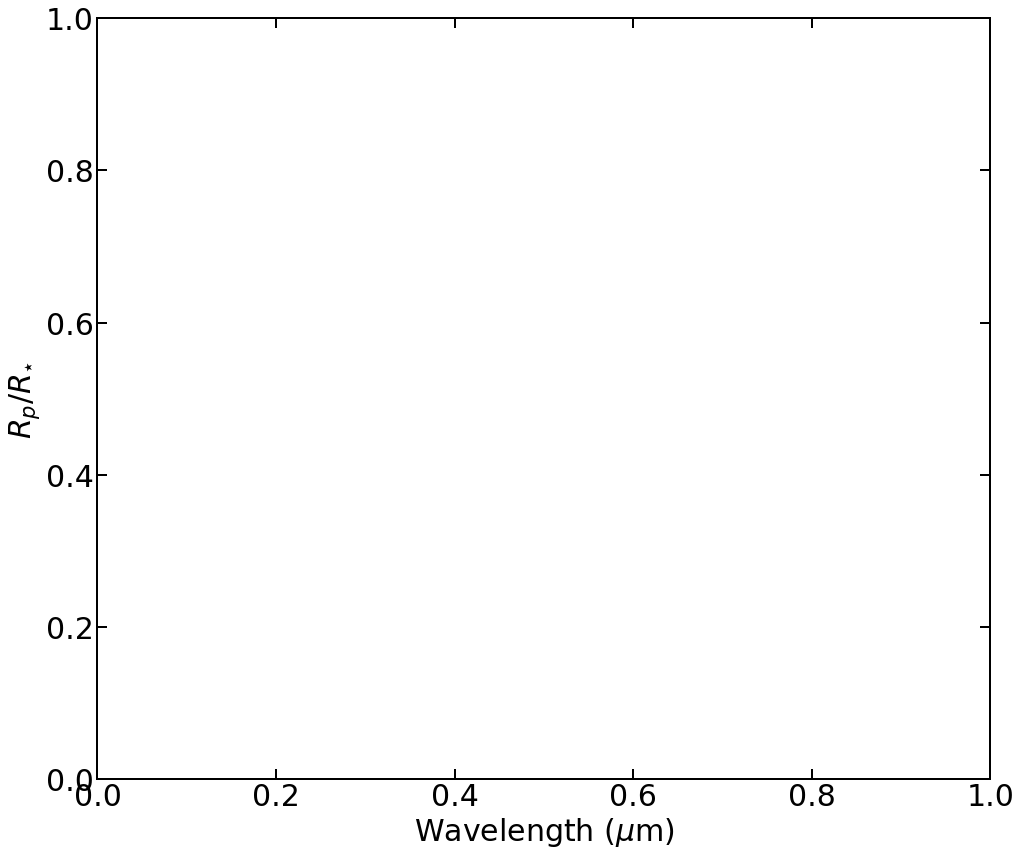

In [7]:
matplotlib.rcParams.update({'font.size': 30})   # adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig = plt.figure(figsize=(16,14))  # adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)

ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('$R_{p}/R_{\star}$')

# Read in spectrum 
psg_model = psg_class()
#model_data = read_model(model_dir + '/' + model_name)

# Get wavelength and transit depth info
psg_model.wavelength = np.array([float(d[0]) for d in model_data])  # Wavelength in microns 
psg_model.Rp = np.array([d[1]*1000 for d in model_data])  # This is in m and is contribution of atmosphere
psg_model.Rp_err = np.array([d[2] for d in model_data])  

ax.plot(psg_model.wavelength,(psg_model.Rp+Rp_m)/Rs_m)

# Let's bin the data to speed up the code.
nbins = 30

bin_means1 = binned_statistic(psg_model.wavelength, psg_model.Rp, bins=nbins)       # Rp
bin_means2 = binned_statistic(psg_model.wavelength, psg_model.Rp_err, bins=nbins)   # Rp_err

bin_wave = []
bin_rp = []
bin_rp_err = []
for i in range(nbins):
    bin_wave.append((bin_means1[1][i]+bin_means1[1][i+1])/2)
    bin_rp.append(bin_means1[0][i])
    bin_rp_err.append(bin_means2[0][i])
bin_wave = np.array(bin_wave)
bin_rp = np.array(bin_rp)
bin_rp_err = np.array(bin_rp_err)

psg_model.wavelength = bin_wave
psg_model.Rp = bin_rp
psg_model.Rp_err = bin_rp_err

ax.plot(psg_model.wavelength,(psg_model.Rp+Rp_m)/Rs_m)

print(psg_model.Rp)

fig.show()

In [8]:
# Read in LD model
ld_model = read_model(specmodel)
ld_model_wv = np.array([d[0]/10000 for d in ld_model])

FileNotFoundError: [Errno 2] No such file or directory: '/genesis/jwst/jwst-ref-soss/star_model_atm/t5000g450p020_ldnl.dat'

In [8]:
# Basic inputs to create the transit data
period = 1.7497798       # Orbital period [days]
b = 0.6                  # Impact parameter
rhostar = 2.48           # Mean stellar density [g/cm³]
rprs_noatmo = Rp_m/Rs_m  # Rp/Rs without atmosphere
tdur = 2.222535*2./24.   # Transit duration [days]          # okay???

In [13]:
# Array to hold transit parameters
sol = np.zeros(18)
sol[0] = rhostar; 
sol[8] = 2*tdur
sol[9] = period
sol[10] = 0.40
obstime = np.arange(0,tdur*4,5/1440)
itime = np.ones(len(obstime))*5/1440

# List to store data
photospectra = []    # Will contain all the observations

rprs_binned = []  # We will save the input r/R* values to compare later.
# Loop over atmosphere model
# for i in range(len(psg_model.Rp)):
for i in range(len(wl)):                            # K.M.
#     sol[11] = (Rp_m+psg_model.Rp[i])/Rs_m    
#     # print('rprs:',sol[11])
#     rprs_binned.append(sol[11])
    
#     # Get limb-darkening (simple closest approach)
#     idx = find_nearest(ld_model_wv, wl[i])   # K.M.

#     sol[1] = ld_model[idx][1]*1
#     sol[2] = ld_model[idx][2]*1
#     sol[3] = ld_model[idx][3]*1
#     sol[4] = ld_model[idx][4]*1

#     model = tf.transitmodel(sol, obstime, itime=itime)
                          
#     zpt = -(ld_model[idx][5])*np.pi*(42.0*ld_model[idx][1]+70.0*ld_model[idx][2]\
#         +90.0*ld_model[idx][3]+105.0*ld_model[idx][4]-210.0)/210.0
#     zpt = np.max([0.0,zpt])
                      
#     model = model*zpt   # Add is spectral baseline
#     noise = np.sqrt(model)/10   # Very rough noise            # ??????????????
#     model += np.random.normal(noise*0,noise)
    
    phot = phot_class()  # Each wavelength has its class (arrays)
    phot.wavelength = np.copy(wl[i])  #psg_model.wavelength[i]        #K.M.
    phot.time = np.copy(obstime)
    phot.flux = np.copy(extracted_flux[:, i])   #model/zpt            #K.M.
#   phot.ferr = np.copy(noise/zpt)
    phot.itime = np.copy(itime)
    
    photospectra.append(phot)  # Stores phot. class
    
# rprs_binned = np.array(rprs_binned)

<ipython-input-16-a8ae39e382e2>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


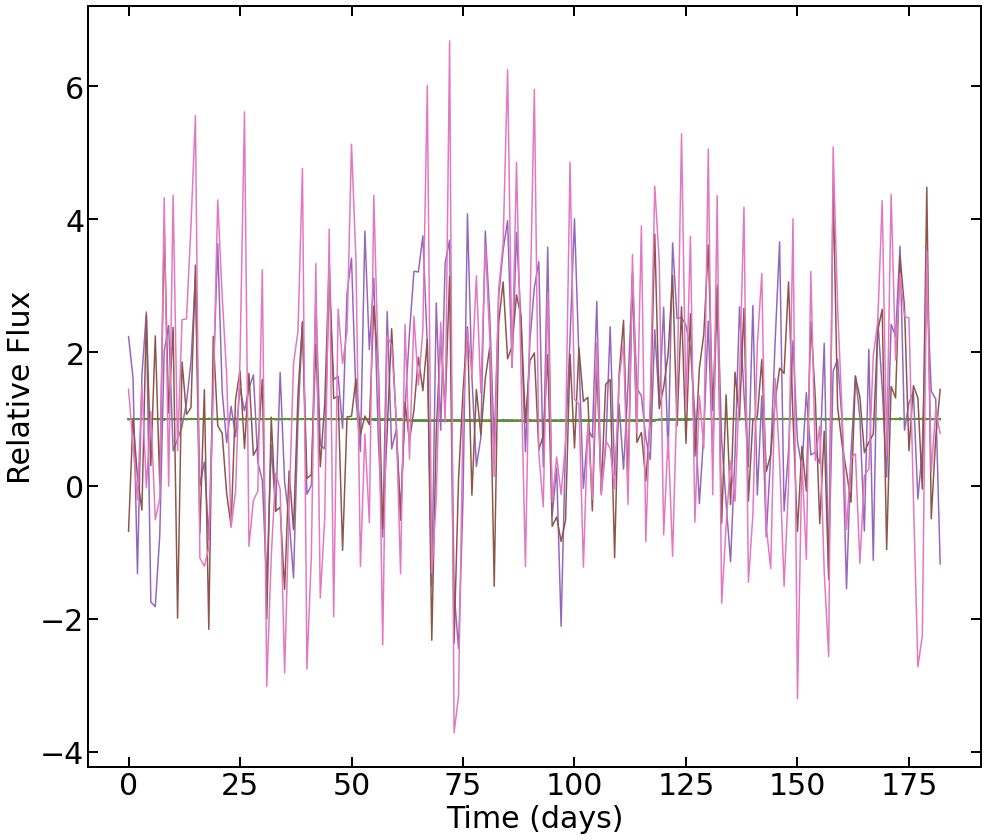

In [16]:
#Show a plot of the data.  Each colour is a different wavelength.
matplotlib.rcParams.update({'font.size': 30})  # Adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig = plt.figure(figsize=(16,14))  # Adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)

ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_xlabel('Time (days)')
ax.set_ylabel('Relative Flux')

for p in photospectra:
    # ax.plot(p.time,p.flux)#/np.median(p.flux))
    ax.plot(np.arange(len(p.flux)),p.flux)
    
fig.show()

## Let's fit the multi-spectrum model

In [22]:
# Number of planets to include
nplanet = 1

# Set up default parameters 
tpars = sptransit_model_parameters([photospectra, nplanet])

# Fill in a few necessary parameters 
# (Overwrites default parameters that were given in def)
tpars.rhostar[0] = np.array([2.48])      # [g/cm³]
tpars.rhostar[3] = np.array([0.1,10.0])  # boundaries for valid models, if needed.    

tpars.period[0][0] = np.array([1.7497798])  # [days]
tpars.period[0][2] = 'fixed'
 
tpars.t0[0][0] = np.array([0.])   # t0: center of transit time   # 0???
tpars.t0[0][3] = np.array([-0.01,+0.01])

tpars.rprs[0][0] = np.ones(len(photospectra))*0.0835            # ???????
tpars.rprs[0][3] = np.array([0.082,0.086])

#Set search scale for zero-point (normalization)
#fmin=np.min(photospectra[0].flux)
#fmax=np.max(photospectra[0].flux)
#for p in photospectra:
#    fmin=np.min([fmin,np.min(p.flux)])
#    fmax=np.max([fmax,np.max(p.flux)])
#tpars.zeropoint[3]=np.array([fmin,fmax])
tpars.zeropoint[3] = np.array([0.998,1.002])

# Simple labels to identify parameters.
clabels = ['p','c1','c2','q1','q2','DIL','VOF','ZPT','EP','PE','BB','RD','EC','ES','KRV','TED','ELL','ALB',\
        'DSC','ASC','LSC']

In [23]:
def lnprob(x):
    ''' 
    ln prob model
    Nested sampling and many MCMC routines use global variables.  Thus, only the fitted parameters are passed.
    Fitted parameters are contained in the input 'x' array.
    '''
    
    logl = 1.0e0   # initialize log-likelihood to some value.
    # check validity of array
    badlpr = -np.inf   # if outside bounds, then mark poor likelihood.
    
    nwav = sol.shape[1]  # number of bandpasses
    npars = sol.shape[0] # number of model parameters
    
    solnew = update_sol(tpars,x,sol)  # contains sol but updated with values from 'x'
    
    # check validity of array
    logl = checksolution(tpars,solnew,badlpr)
    
    if logl>badlpr:
    
        for i in range(nwav):
            dscale = solnew[npars-3][i]   # photometric scale
            ascale = solnew[npars-2][i]   # photometric scale
            lscale = solnew[npars-1][i]   # length scale for GP

            # check dscale, ascale and lscale hyper parameters (they must be positive)
            if (dscale <= 0.0) & (tpars.error_scale[2]=='fit'):
                logl = badlpr
            if (ascale <= 0.0) & (tpars.amplitude_scale[2]=='fit'):
                logl = badlpr
            if (lscale <= 0.0) & (tpars.length_scale[2]=='fit'):
                logl = badlpr

            if (tpars.amplitude_scale[2]=='fit')|(tpars.length_scale[2]=='fit'):
                modeltype = 1   # GP model
            else:
                modeltype = 0   # uncorrelated noise model

            npt = len(photospectra[i].time)   # number of data points

            sol1 = np.array([s[i] for s in solnew])

            # zpt=np.copy(sol1[7])
            sol1[7] -= 1.0 

            if logl>badlpr:  # check that we have a valid model to use
                # Retrieve transit model using sol3 array 
                ans = tf.transitmodel(sol1, photospectra[i].time, itime=photospectra[i].itime, \
                                       ntt=tpars.ntt, tobs=tpars.tobs, omc=tpars.omc)
                #ans = ans*zpt #put in zero-point

                if np.isnan(np.sum(ans))==False:  # check for NaNs -- we don't want these.

                    if modeltype==0:   # non-correlated noise-model
                        logl += -0.5*(sum(np.log(photospectra[i].ferr*photospectra[i].ferr*dscale*dscale))\
                             +sum((photospectra[i].flux-ans)*(photospectra[i].flux-ans)/\
                                  (photospectra[i].ferr*photospectra[i].ferr*dscale*dscale)))
                else:
                    logl = badlpr

            #plt.plot(photospectra[i].time,photospectra[i].flux)
            #plt.plot(photospectra[i].time,ans)
            #plt.show()
            #Add Priors here...
       
    return logl

In [24]:
nwalkers = 3      # Number of walkers for MCMC
nsteps1 = 10000   # Total length of chain will be nwalkers*nsteps
nsteps2 = 200000  # nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc = 100000
burninf = 0.5     # burn-in for evalulating convergence
niter_cor = 5000
burnin_cor = 1000
nthin = 101
nloopmax = 5
converge_crit = 1.02     # Convergence criteria
buf_converge_crit = 1.2  # Convergence criteria for buffer
itermax = 5  # Maximum iterations allowed

sol = get_all_parameters(tpars, photospectra)  # Creates internal array used to create transit model.
x = get_fitted_parameters(tpars)
tran_par_names = get_names(clabels, tpars)
beta = np.random.rand(len(x))*1.0e-5

In [25]:
corscale = betarescale(x, beta, niter_cor, burnin_cor, mhgmcmc, lnprob, imax=10)

Current Acceptance:  [0.67857143 1.         1.         1.         0.96551724 1.
 1.         0.97916667 1.         1.         0.97368421 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.96774194 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.96666667 1.         0.97058824 1.         1.
 1.         1.         1.         0.96428571 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.78571429 0.8        0.78571429 0.48484848 0.66666667
 0.65384615 0.86363636 0.6969697  0.82857143 0.83333333 0.69565217
 0.8        0.76       0.87878788 0.81481481 0.82758621 0.7
 0.7037037  1.         0.87096774 0.88235294 0.82051282 0.96875
 0.97560976 0.67741935 0.78125    0.90625    0.90909091 1.
 0.92592593 0.96774194 1.         0.87179487 0.77419355 0.69230769
 0.66

Current Acceptance:  [0.46428571 0.62068966 0.59183673 0.6        0.38709677 0.65517241
 0.73076923 0.67567568 0.38888889 0.51515152 0.60869565 0.65714286
 0.66666667 0.39473684 0.51111111 0.66666667 0.44827586 0.65384615
 0.61538462 0.51428571 0.51724138 0.58333333 0.41666667 0.63636364
 0.57142857 0.5483871  0.53333333 0.59375    0.51282051 0.63636364
 0.60714286 0.72222222 0.92105263 0.67857143 0.525      0.6969697
 0.69230769 0.62162162 0.66666667 0.59375    0.57575758 0.52631579
 0.57142857 0.53571429 0.48387097 0.5        0.55555556 0.46666667
 0.64285714 0.6744186  0.63157895 0.54545455 0.4516129  0.65217391
 0.79310345 0.71428571 0.77777778 0.66666667 0.57142857 0.71428571
 0.81578947 0.31034483 0.23529412 0.23809524 0.46875    0.34615385
 0.27272727 0.12903226 0.18918919 0.27586207 0.22222222 0.25
 0.22727273 0.34482759 0.37142857 0.26315789 0.33333333 0.25
 0.12903226 0.2173913  0.22857143 0.16216216 0.22857143 0.17241379
 0.40540541 0.22222222 0.15151515 0.12       0.2121212

In [26]:
nloop = 0
nsteps = np.copy(nsteps1)
mcmcloop = True
while mcmcloop==True:

    nloop += 1   # Count number of loops

    hchain1,haccept1 = genchain(x, nsteps, beta*corscale, mhgmcmc, lnprob)
    hchain2,haccept2 = genchain(x, nsteps, beta*corscale, mhgmcmc, lnprob)
    hchain3,haccept3 = genchain(x, nsteps, beta*corscale, mhgmcmc, lnprob)

    if nloop==1:
        chain1 = np.copy(hchain1)
        chain2 = np.copy(hchain2)
        chain3 = np.copy(hchain3)
        accept1 = np.copy(haccept1)
        accept2 = np.copy(haccept2)
        accept3 = np.copy(haccept3)
    else:
        chain1 = np.concatenate((chain1, hchain1))
        chain2 = np.concatenate((chain2, hchain2))
        chain3 = np.concatenate((chain3, hchain3))
        accept1 = np.concatenate((accept1, haccept1))
        accept2 = np.concatenate((accept2, haccept2))
        accept3 = np.concatenate((accept3, haccept3))

    burnin = int(chain1.shape[0]*burninf)
    calcacrate(accept1, burnin)

    grtest = gelmanrubin(chain1, chain2, chain3, burnin=burnin, npt=len(phot.time))
    print('Gelman-Rubin Convergence:')
    print('parameter  Rc')
    for i in range(0,len(chain1[1,:])):
        print('%8s %3s %.4f' %(str(i),tran_par_names[i],grtest[i]))
    if int(np.sum(grtest[grtest<buf_converge_crit]/grtest[grtest<buf_converge_crit]))==len(grtest):
        mcmcloop = False
    else:
        mcmcloop = True
        nsteps += nsteps1

    #runtest=np.array(tf.checkperT0(chain1,burninf,TPnthin,sol,serr))
    #print('runtest:',runtest)
    #if int(np.sum(runtest[runtest<1.0]/runtest[runtest<1.0]))!=4.0:
    #    mcmcloop=False #run-away

    if nloop>=nloopmax:  # Break if too many loops
        mcmcloop = False

    #print("---- %s seconds ----" % (time.time() - start_time))

Global Acceptance Rate: 0.364
0 Acceptance Rate 0.576
1 Acceptance Rate 0.188
2 Acceptance Rate 0.439
3 Acceptance Rate 0.339
4 Acceptance Rate 0.488
5 Acceptance Rate 0.400
6 Acceptance Rate 0.500
7 Acceptance Rate 0.417
8 Acceptance Rate 0.447
9 Acceptance Rate 0.486
10 Acceptance Rate 0.513
11 Acceptance Rate 0.545
12 Acceptance Rate 0.600
13 Acceptance Rate 0.571
14 Acceptance Rate 0.528
15 Acceptance Rate 0.429
16 Acceptance Rate 0.511
17 Acceptance Rate 0.587
18 Acceptance Rate 0.558
19 Acceptance Rate 0.350
20 Acceptance Rate 0.514
21 Acceptance Rate 0.583
22 Acceptance Rate 0.486
23 Acceptance Rate 0.351
24 Acceptance Rate 0.132
25 Acceptance Rate 0.565
26 Acceptance Rate 0.292
27 Acceptance Rate 0.409
28 Acceptance Rate 0.186
29 Acceptance Rate 0.278
30 Acceptance Rate 0.156
31 Acceptance Rate 0.146
32 Acceptance Rate 0.333
33 Acceptance Rate 0.562
34 Acceptance Rate 0.462
35 Acceptance Rate 0.524
36 Acceptance Rate 0.484
37 Acceptance Rate 0.538
38 Acceptance Rate 0.318
39 Ac

110 Acceptance Rate 0.181
111 Acceptance Rate 0.214
112 Acceptance Rate 0.311
113 Acceptance Rate 0.304
114 Acceptance Rate 0.276
115 Acceptance Rate 0.299
116 Acceptance Rate 0.286
117 Acceptance Rate 0.248
118 Acceptance Rate 0.224
119 Acceptance Rate 0.064
120 Acceptance Rate 0.074
121 Acceptance Rate 0.125
122 Acceptance Rate 0.177
123 Acceptance Rate 0.488
Gelman-Rubin Convergence:
parameter  Rc
       0   p 1.3824
       1  q1 1.3369
       2  q1 1.0594
       3  q1 1.1415
       4  q1 1.0128
       5  q1 1.1790
       6  q1 1.0625
       7  q1 1.1367
       8  q1 1.0110
       9  q1 1.0724
      10  q1 1.0248
      11  q1 1.0938
      12  q1 1.1904
      13  q1 1.0497
      14  q1 1.0595
      15  q1 1.0397
      16  q1 1.4355
      17  q1 1.0454
      18  q1 1.0410
      19  q1 1.1383
      20  q1 1.0265
      21  q1 1.0667
      22  q1 1.0662
      23  q1 1.0906
      24  q1 1.0832
      25  q1 1.1428
      26  q1 1.1040
      27  q1 1.0653
      28  q1 1.0640
      29  q1 1.1

Global Acceptance Rate: 0.392
0 Acceptance Rate 0.549
1 Acceptance Rate 0.203
2 Acceptance Rate 0.483
3 Acceptance Rate 0.299
4 Acceptance Rate 0.623
5 Acceptance Rate 0.572
6 Acceptance Rate 0.545
7 Acceptance Rate 0.526
8 Acceptance Rate 0.537
9 Acceptance Rate 0.559
10 Acceptance Rate 0.516
11 Acceptance Rate 0.570
12 Acceptance Rate 0.496
13 Acceptance Rate 0.558
14 Acceptance Rate 0.584
15 Acceptance Rate 0.540
16 Acceptance Rate 0.568
17 Acceptance Rate 0.413
18 Acceptance Rate 0.448
19 Acceptance Rate 0.380
20 Acceptance Rate 0.593
21 Acceptance Rate 0.518
22 Acceptance Rate 0.230
23 Acceptance Rate 0.137
24 Acceptance Rate 0.207
25 Acceptance Rate 0.321
26 Acceptance Rate 0.235
27 Acceptance Rate 0.198
28 Acceptance Rate 0.338
29 Acceptance Rate 0.343
30 Acceptance Rate 0.304
31 Acceptance Rate 0.200
32 Acceptance Rate 0.251
33 Acceptance Rate 0.653
34 Acceptance Rate 0.710
35 Acceptance Rate 0.542
36 Acceptance Rate 0.720
37 Acceptance Rate 0.549
38 Acceptance Rate 0.437
39 Ac

103 Acceptance Rate 0.296
104 Acceptance Rate 0.285
105 Acceptance Rate 0.262
106 Acceptance Rate 0.265
107 Acceptance Rate 0.364
108 Acceptance Rate 0.356
109 Acceptance Rate 0.138
110 Acceptance Rate 0.232
111 Acceptance Rate 0.194
112 Acceptance Rate 0.257
113 Acceptance Rate 0.360
114 Acceptance Rate 0.281
115 Acceptance Rate 0.301
116 Acceptance Rate 0.245
117 Acceptance Rate 0.279
118 Acceptance Rate 0.245
119 Acceptance Rate 0.135
120 Acceptance Rate 0.151
121 Acceptance Rate 0.110
122 Acceptance Rate 0.246
123 Acceptance Rate 0.588
Gelman-Rubin Convergence:
parameter  Rc
       0   p 1.0889
       1  q1 1.0379
       2  q1 1.0267
       3  q1 1.0527
       4  q1 1.0148
       5  q1 1.0311
       6  q1 1.0119
       7  q1 1.0240
       8  q1 1.0133
       9  q1 1.0129
      10  q1 1.0111
      11  q1 1.0111
      12  q1 1.0260
      13  q1 1.0154
      14  q1 1.0174
      15  q1 1.0145
      16  q1 1.0225
      17  q1 1.0166
      18  q1 1.0239
      19  q1 1.0164
      20  q1 1

In [19]:
mcmcloop = True
nloop = 0
nsteps = np.copy(nsteps2)
while mcmcloop==True:

    nloop += 1  # Count number of loops

    burnin = int(chain1.shape[0]*burninf)
    buffer = np.concatenate((chain1[burnin:],chain2[burnin:],chain3[burnin:]))  # Create buffer for deMCMC
    x1 = np.copy(chain1[chain1.shape[0]-1,:])
    x2 = np.copy(chain1[chain1.shape[0]-1,:])
    x3 = np.copy(chain1[chain1.shape[0]-1,:])
    corbeta = 0.3
    burnin = int(chain1.shape[0]*burninf)
    chain1, accept1 = genchain(x1,nsteps,beta*corscale,demhmcmc,lnprob,buffer=buffer,\
                              corbeta=corbeta,progress=True)
    chain2, accept2 = genchain(x2,nsteps,beta*corscale,demhmcmc,lnprob,buffer=buffer,\
                              corbeta=corbeta,progress=True)
    chain3, accept3 = genchain(x3,nsteps,beta*corscale,demhmcmc,lnprob,buffer=buffer,\
                              corbeta=corbeta,progress=True)

    burnin = int(chain1.shape[0]*burninf)
    grtest = gelmanrubin(chain1,chain2,chain3,burnin=burnin,npt=len(phot.time))
    print('Gelman-Rubin Convergence:')
    print('parameter  Rc')
    for i in range(0,len(chain1[1,:])):
        print('%8s %3s %.4f' %(str(i),tran_par_names[i],grtest[i]))

    if int(np.sum(grtest[grtest<converge_crit]/grtest[grtest<converge_crit]))==len(grtest):
        mcmcloop = False
    else:
        mcmcloop = True

    burnin = int(chain1.shape[0]*burninf)
    chain = np.concatenate((chain1[burnin:,],chain2[burnin:,],chain3[burnin:,]))
    accept = np.concatenate((accept1[burnin:,],accept2[burnin:,],accept3[burnin:,]))
    burnin = int(chain.shape[0]*burninf)
    calcacrate(accept,burnin)

    nsteps += nsteps_inc  # Make longer chain to help with convergence

    ##check for run-away Chain.
    #runtest=np.array(tf.checkperT0(chain1,burninf,nthin,sol,serr))
    #print('runtest:',runtest)
    #if int(np.sum(runtest[runtest<1.0]/runtest[runtest<1.0]))!=4.0:
    #    mcmcloop=False #run-away

    if nloop>=nloopmax:   # Break if too many loops
        mcmcloop = False

    #print("---- %s seconds ----" % (time.time() - start_time))

#print("done %s seconds ---" % (time.time() - start_time))


Gelman-Rubin Convergence:
parameter  Rc
       0   p 1.5762
       1  q1 1.1857
       2  q1 1.0346
       3  q1 1.2159
       4  q1 1.2100
       5  q1 1.1343
       6  q1 1.1477
       7  q1 1.2596
       8  q1 1.1817
       9  q1 1.0984
      10  q1 1.1056
      11  q1 1.0274
      12  q1 1.1411
      13  q1 1.0179
      14  q1 1.1638
      15  q1 1.1538
      16  q1 1.0343
      17  q1 1.0246
      18  q1 1.0673
      19  q1 1.0842
      20  q1 1.0738
      21  q1 1.1099
      22  q1 1.0450
      23  q1 1.1136
      24  q1 1.0478
      25  q1 1.0596
      26  q1 1.0946
      27  q1 1.1281
      28  q1 1.0140
      29  q1 1.0199
      30  q1 1.0155
      31  q2 1.0868
      32  q2 1.0141
      33  q2 1.2778
      34  q2 1.1297
      35  q2 1.0120
      36  q2 1.0587
      37  q2 1.9814
      38  q2 2.5318
      39  q2 1.0438
      40  q2 1.1615
      41  q2 1.4160
      42  q2 1.4452
      43  q2 1.0552
      44  q2 1.0918
      45  q2 1.3181
      46  q2 2.4544
      47  q2 1.0172


Gelman-Rubin Convergence:
parameter  Rc
       0   p 2.9461
       1  q1 1.1963
       2  q1 1.2193
       3  q1 1.0593
       4  q1 1.1241
       5  q1 1.2834
       6  q1 1.1992
       7  q1 1.2755
       8  q1 1.1358
       9  q1 1.2839
      10  q1 1.1670
      11  q1 1.5164
      12  q1 1.0167
      13  q1 1.0908
      14  q1 1.2084
      15  q1 1.2290
      16  q1 1.7447
      17  q1 1.0450
      18  q1 1.1350
      19  q1 1.2537
      20  q1 1.0265
      21  q1 1.0562
      22  q1 1.1700
      23  q1 1.0871
      24  q1 1.3279
      25  q1 1.2774
      26  q1 1.3504
      27  q1 1.1549
      28  q1 1.0535
      29  q1 1.0278
      30  q1 1.0525
      31  q2 1.1539
      32  q2 1.1804
      33  q2 1.0313
      34  q2 1.1298
      35  q2 1.2203
      36  q2 1.0978
      37  q2 1.2166
      38  q2 1.0775
      39  q2 1.3673
      40  q2 1.0985
      41  q2 1.7138
      42  q2 1.1039
      43  q2 1.1384
      44  q2 1.0923
      45  q2 1.1289
      46  q2 1.7051
      47  q2 1.0260


Gelman-Rubin Convergence:
parameter  Rc
       0   p 3.0009
       1  q1 1.0258
       2  q1 1.0229
       3  q1 1.1088
       4  q1 1.0195
       5  q1 1.0148
       6  q1 1.0597
       7  q1 1.1434
       8  q1 1.0416
       9  q1 1.1196
      10  q1 1.0447
      11  q1 1.0428
      12  q1 1.0988
      13  q1 1.0344
      14  q1 1.1081
      15  q1 1.0559
      16  q1 1.0870
      17  q1 1.0205
      18  q1 1.0724
      19  q1 1.0258
      20  q1 1.0150
      21  q1 1.0890
      22  q1 1.0769
      23  q1 1.0951
      24  q1 1.0192
      25  q1 1.0979
      26  q1 1.0201
      27  q1 1.0414
      28  q1 1.0667
      29  q1 1.0364
      30  q1 1.0682
      31  q2 1.0212
      32  q2 1.0290
      33  q2 1.0979
      34  q2 1.0211
      35  q2 1.0226
      36  q2 1.0272
      37  q2 1.0478
      38  q2 1.0211
      39  q2 1.0830
      40  q2 1.0408
      41  q2 1.0282
      42  q2 1.0943
      43  q2 1.0291
      44  q2 1.0369
      45  q2 1.0191
      46  q2 1.0380
      47  q2 1.0119


Gelman-Rubin Convergence:
parameter  Rc
       0   p 1.5139
       1  q1 1.0151
       2  q1 1.0638
       3  q1 1.2181
       4  q1 1.2080
       5  q1 1.1735
       6  q1 1.1836
       7  q1 1.1011
       8  q1 1.0600
       9  q1 1.2475
      10  q1 1.2274
      11  q1 1.2160
      12  q1 1.1324
      13  q1 1.1755
      14  q1 1.0733
      15  q1 1.2391
      16  q1 1.1425
      17  q1 1.0387
      18  q1 1.0226
      19  q1 1.1101
      20  q1 1.2219
      21  q1 1.1409
      22  q1 1.0660
      23  q1 1.0423
      24  q1 1.0520
      25  q1 1.0551
      26  q1 1.0723
      27  q1 1.0156
      28  q1 1.0950
      29  q1 1.0245
      30  q1 1.0382
      31  q2 1.0139
      32  q2 1.0328
      33  q2 1.0864
      34  q2 1.0862
      35  q2 1.0687
      36  q2 1.0482
      37  q2 1.0778
      38  q2 1.0112
      39  q2 1.1010
      40  q2 1.1187
      41  q2 1.1078
      42  q2 1.0603
      43  q2 1.0701
      44  q2 1.0148
      45  q2 1.0394
      46  q2 1.0742
      47  q2 1.0132


Gelman-Rubin Convergence:
parameter  Rc
       0   p 1.0308
       1  q1 1.0194
       2  q1 1.0112
       3  q1 1.0189
       4  q1 1.0334
       5  q1 1.0502
       6  q1 1.0199
       7  q1 1.0251
       8  q1 1.0287
       9  q1 1.0124
      10  q1 1.0128
      11  q1 1.0231
      12  q1 1.0191
      13  q1 1.0140
      14  q1 1.0126
      15  q1 1.0165
      16  q1 1.0170
      17  q1 1.0151
      18  q1 1.0225
      19  q1 1.0336
      20  q1 1.0127
      21  q1 1.0149
      22  q1 1.0121
      23  q1 1.0161
      24  q1 1.0256
      25  q1 1.0352
      26  q1 1.0154
      27  q1 1.0121
      28  q1 1.0136
      29  q1 1.0195
      30  q1 1.0130
      31  q2 1.0222
      32  q2 1.0119
      33  q2 1.0209
      34  q2 1.0425
      35  q2 1.0505
      36  q2 1.0238
      37  q2 1.0332
      38  q2 1.0330
      39  q2 1.0116
      40  q2 1.0110
      41  q2 1.0200
      42  q2 1.0123
      43  q2 1.0124
      44  q2 1.0145
      45  q2 1.0140
      46  q2 1.0163
      47  q2 1.0188

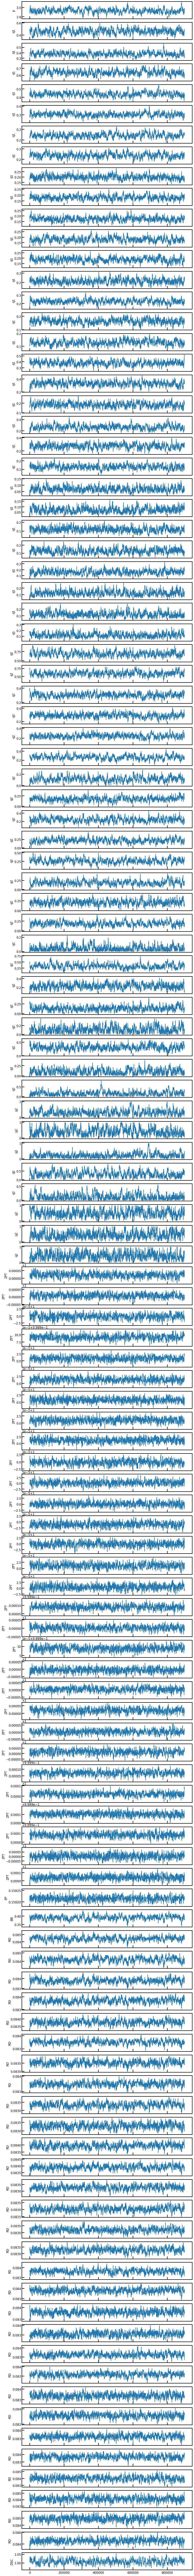

In [31]:
matplotlib.rcParams.update({'font.size': 12}) #adjust font
plotchains(chain,0,tran_par_names)

In [32]:
npars = len(chain[1,:])
mm = np.zeros(npars)
for i in range(0, npars):
    mode,x_eval,kde1 = tf.modekdestimate(chain[::10,i],0)
    mm[i] = mode
    perc1 = tf.intperc(mode,x_eval,kde1)#,perc=0.997)
    print('%s = %.8f +%.8f -%.8f (1 Sigma)' %(tran_par_names[i],mode,np.abs(perc1[1]-mode),np.abs(mode-perc1[0])))

p = 2.91684389 +0.05328605 -0.03586561 (1 Sigma)
q1 = 0.45397971 +0.04930824 -0.03588401 (1 Sigma)
q1 = 0.38395248 +0.03091413 -0.03929272 (1 Sigma)
q1 = 0.62515124 +0.04720772 -0.02065338 (1 Sigma)
q1 = 0.43174796 +0.02953027 -0.02037215 (1 Sigma)
q1 = 0.29962950 +0.02660885 -0.02017987 (1 Sigma)
q1 = 0.24477213 +0.01712552 -0.02415137 (1 Sigma)
q1 = 0.23341694 +0.02594434 -0.01859594 (1 Sigma)
q1 = 0.19728288 +0.02127962 -0.01893152 (1 Sigma)
q1 = 0.17195349 +0.02470087 -0.01087375 (1 Sigma)
q1 = 0.17105638 +0.02121295 -0.01648303 (1 Sigma)
q1 = 0.17669331 +0.02170064 -0.02082678 (1 Sigma)
q1 = 0.18798027 +0.01940578 -0.02244699 (1 Sigma)
q1 = 0.20555729 +0.03186414 -0.01658906 (1 Sigma)
q1 = 0.21922749 +0.03135563 -0.01737782 (1 Sigma)
q1 = 0.16318320 +0.01825648 -0.01756756 (1 Sigma)
q1 = 0.12076571 +0.02667908 -0.01259153 (1 Sigma)
q1 = 0.37359469 +0.04107457 -0.03244106 (1 Sigma)
q1 = 0.31976335 +0.04596898 -0.02626799 (1 Sigma)
q1 = 0.17380857 +0.03534030 -0.01519303 (1 Sigma)
q

In [27]:
npars = len(chain[1,:])
mm = np.zeros(npars)

nthin = 10
chain_thin = chain[::nthin,:]


rprs_model = []
rprs_model_ep = []
rprs_model_em = []
for i in range(93,123):
    mode, x_eval, kde1 = tf.modekdestimate(chain_thin[:,i], 0)
    mm[i] = mode
    perc1 = tf.intperc(mode, x_eval, kde1) #, perc=0.997)
    rprs_model.append(mode)
    rprs_model_ep.append( np.abs(perc1[1]-mode))
    rprs_model_em.append(-np.abs(mode-perc1[0]))
    print('%s = %.8f +%.8f -%.8f (1 Sigma)' %(tran_par_names[i],mode,np.abs(perc1[1]-mode),np.abs(mode-perc1[0])))
    
rprs_model = np.array(rprs_model)
rprs_model_ep = np.array(rprs_model_ep)
rprs_model_em = np.array(rprs_model_em)

RD = 0.08447040 +0.00027524 -0.00031133 (1 Sigma)
RD = 0.08429538 +0.00019984 -0.00037166 (1 Sigma)
RD = 0.08378991 +0.00020313 -0.00023778 (1 Sigma)
RD = 0.08372409 +0.00015338 -0.00021523 (1 Sigma)
RD = 0.08375552 +0.00017420 -0.00014823 (1 Sigma)
RD = 0.08351564 +0.00015101 -0.00016419 (1 Sigma)
RD = 0.08360124 +0.00005734 -0.00023224 (1 Sigma)
RD = 0.08346874 +0.00016410 -0.00013658 (1 Sigma)
RD = 0.08327602 +0.00020904 -0.00009820 (1 Sigma)
RD = 0.08333091 +0.00010559 -0.00019464 (1 Sigma)
RD = 0.08397049 +0.00014545 -0.00018953 (1 Sigma)
RD = 0.08390056 +0.00016787 -0.00016669 (1 Sigma)
RD = 0.08330331 +0.00012996 -0.00020162 (1 Sigma)
RD = 0.08305331 +0.00016028 -0.00017495 (1 Sigma)
RD = 0.08317712 +0.00016339 -0.00013989 (1 Sigma)
RD = 0.08328253 +0.00016437 -0.00018733 (1 Sigma)
RD = 0.08372545 +0.00010901 -0.00031038 (1 Sigma)
RD = 0.08377331 +0.00021616 -0.00019333 (1 Sigma)
RD = 0.08355841 +0.00023019 -0.00015123 (1 Sigma)
RD = 0.08301124 +0.00033189 -0.00016513 (1 Sigma)


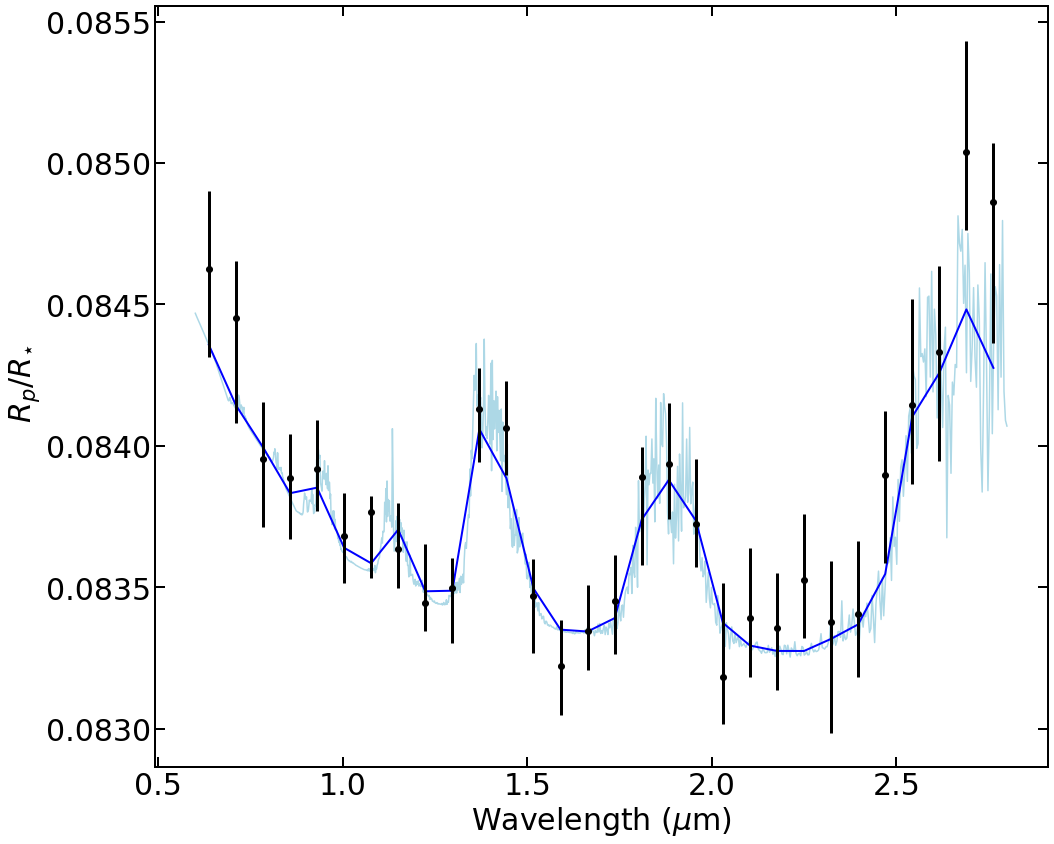

In [30]:
matplotlib.rcParams.update({'font.size': 30})  # Adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig = plt.figure(figsize=(16,14))  # Adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)

ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel(' $R_{p}/R_{\star}$')


#rprs_binned=np.array([0.08425564673418401, 0.08391695345274379, 0.08375053190856288, 0.08364267099710652, \
#                     0.08348632677920928, 0.083973083683014,   0.08342468358830134, 0.08336638722554368, \
#                     0.08380774401419508, 0.08355463168731934, 0.0832839245500194,  0.08329519340547527, \
#                     0.08345741726828987, 0.08418017555669018, 0.08437886537394856])

# Get wavelength and transit depth info
psg_model.wavelength = np.array([float(d[0]) for d in model_data])  # Wavelength in microns 
psg_model.Rp = np.array([d[1]*1000 for d in model_data])  # This is in m and is contribution of atmosphere
psg_model.Rp_err = np.array([d[2] for d in model_data]) 

ax.plot(psg_model.wavelength,(psg_model.Rp+Rp_m)/Rs_m,c='lightblue',zorder=0)
ax.plot(tpars.wavelength,rprs_binned,zorder=1,c='blue',lw=2)

ax.errorbar(tpars.wavelength,rprs_model*0.99+0.001,np.array([-rprs_model_em,rprs_model_ep]),fmt='o',lw=3,c='black',\
            zorder=2)

fig.show()

In [ ]:
#Corner is SLOW
#figure = corner.corner(chain,quantiles=[0.16, 0.5, 0.84],show_titles=True,labels=tran_par_names)